### 피트 스톱 전략 승패 분석: Undercut vs Overcut

**분석 목표**
1. **피트 로스(Pit Loss) 정량화:** 서킷별로 타이어 교체에 소요되는 시간 손실(Time Loss)을 실제 데이터로 계산합니다.
2. **언더컷(Undercut) 효과 분석:** 먼저 피트인하여 새 타이어의 성능 이득(Gain)으로 앞차를 추월하는 전략의 성공률과 조건을 분석합니다.
3. **전략 시각화 (Race Trace):** 주요 배틀 상황에서의 랩별 간격 변화(Gap Evolution)를 시각화하여 승부처를 포착합니다.

In [18]:
# 라이브러리 및 DB 연결
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pymongo import MongoClient
import warnings

warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# DB 연결
client = MongoClient("mongodb://localhost:27017/")
db = client["f1_analytics_db"]
print("✅ DB Connected")

✅ DB Connected


In [19]:
# 전수 조사 함수: 2023~2025 모든 언더컷 탐지
def analyze_all_seasons(years):
    all_battles = []

    # 해당 연도의 모든 레이스 메타데이터 조회
    races = list(db.races_meta.find({"Year": {"$in": years}}, {"Year": 1, "Round": 1, "Circuit": 1}))
    print(f"🚀 총 {len(races)}개 그랑프리 분석 시작...")

    for race in races:
        year, round_num = race['Year'], race['Round']

        # [수정됨] 서킷 이름 영문 통일 & 'Grand Prix' 제거
        circuit = race['Circuit'].replace("Grand Prix", "").strip()

        # 1. 랩 데이터 로드
        projection = {
            "Driver": 1, "LapNumber": 1, "LapTime_Sec": 1,
            "PitInTime": 1, "PitOutTime": 1, "IsAccurate": 1
        }
        df = pd.DataFrame(list(db.laps.find(
            {"SessionType": "Race", "Year": year, "Round": round_num},
            projection
        )))

        if df.empty: continue

        # 2. 전처리 (순위, 누적시간, 피트스톱)
        df = df.sort_values(by=['Driver', 'LapNumber'])
        df['CumTime'] = df.groupby('Driver')['LapTime_Sec'].cumsum()
        df['Position'] = df.groupby('LapNumber')['CumTime'].rank(method='min')
        df['Is_PitStop'] = df['PitInTime'].notna() | df['PitOutTime'].notna()

        # 3. 언더컷 탐지 로직
        pivot_cum = df.pivot(index='LapNumber', columns='Driver', values='CumTime')
        pit_info = df[df['Is_PitStop']].groupby('Driver')['LapNumber'].apply(list).to_dict()

        max_lap = int(df['LapNumber'].max())

        for lap in range(5, max_lap - 5):
            try:
                rank = df[df['LapNumber'] == lap].sort_values('Position')
                rank_list = rank['Driver'].tolist()

                for i in range(len(rank_list)-1):
                    leader, chaser = rank_list[i], rank_list[i+1]

                    if leader not in pivot_cum.columns or chaser not in pivot_cum.columns: continue

                    # 간격 확인 (3초 이내)
                    gap = pivot_cum.at[lap, chaser] - pivot_cum.at[lap, leader]
                    if gap > 3.0 or gap < 0: continue

                    # 언더컷 시도 확인
                    chaser_pits = pit_info.get(chaser, [])
                    leader_pits = pit_info.get(leader, [])

                    if (lap + 1) in chaser_pits and (lap + 1) not in leader_pits:
                        leader_pit_lap = next((l for l in leader_pits if l > lap + 1), None)

                        if leader_pit_lap:
                            check_lap = leader_pit_lap + 1 # 승부 확인 랩
                            if check_lap in pivot_cum.index:
                                gap_after = pivot_cum.at[check_lap, chaser] - pivot_cum.at[check_lap, leader]
                                is_success = 1 if gap_after < 0 else 0

                                all_battles.append({
                                    'Season': year,
                                    'Circuit': circuit, # 수정된 영어 이름 사용
                                    'Chaser': chaser,
                                    'Leader': leader,
                                    'Gap_Before': gap,
                                    'Gap_After': gap_after,
                                    'Pit_Diff': leader_pit_lap - (lap + 1),
                                    'Is_Success': is_success
                                })
            except: continue

    return pd.DataFrame(all_battles).drop_duplicates()

# 분석 실행
df_undercuts = analyze_all_seasons([2023, 2024, 2025])
print(f"📊 분석 완료: 총 {len(df_undercuts)} 건의 언더컷 시도 발견")

🚀 총 136개 그랑프리 분석 시작...
📊 분석 완료: 총 1076 건의 언더컷 시도 발견


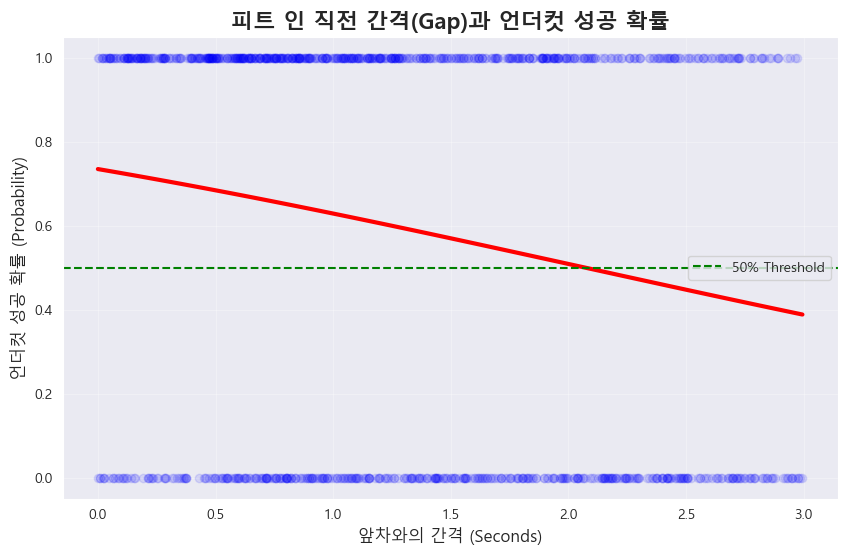

In [20]:
# 시각화 1: 피트 전 간격(Gap)에 따른 성공률 (로지스틱 회귀 시각화)
# "몇 초 차이일 때 들어와야 성공할까?"
plt.figure(figsize=(10, 6))

sns.regplot(
    x='Gap_Before', y='Is_Success',
    data=df_undercuts,
    logistic=True,
    ci=None,
    line_kws={'color': 'red', 'linewidth': 3},
    scatter_kws={'alpha': 0.1, 'color': 'blue'}
)

plt.title('피트 인 직전 간격(Gap)과 언더컷 성공 확률', fontsize=16, fontweight='bold')
plt.xlabel('앞차와의 간격 (Seconds)', fontsize=12)
plt.ylabel('언더컷 성공 확률 (Probability)', fontsize=12)
plt.axhline(0.5, color='green', linestyle='--', label='50% Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
# 시각화 2: 서킷별 언더컷 난이도 (성공률)
# "어디서 언더컷이 잘 먹히나?"
circuit_stats = df_undercuts.groupby('Circuit')['Is_Success'].agg(['mean', 'count'])
# 신뢰도를 위해 샘플 5개 이상인 서킷만 표시
circuit_stats = circuit_stats[circuit_stats['count'] > 5].sort_values('mean', ascending=False)

fig = px.bar(
    circuit_stats,
    x=circuit_stats.index,
    y='mean',
    text_auto='.1%',
    title='<b>서킷별 언더컷 전략 성공률 (2023-2025)</b>',
    labels={'Circuit': '서킷', 'mean': '성공률'},
    color='mean',
    color_continuous_scale='RdBu'
)

fig.add_hline(y=0.5, line_dash="dash", line_color="red", annotation_text="50% Cutline")
fig.update_layout(
    template='plotly_white',
    title_font_size=20,
    xaxis_tickangle=-45
)
fig.show()

In [24]:
# 시각화 3: '몇 랩'을 더 버텨야 막을 수 있나? (Pit Difference)
# 리더가 늦게 들어올수록(Overcut) 방어가 될까, 아니면 더 망할까?

fig = px.box(
    df_undercuts,
    x='Is_Success',
    y='Pit_Diff',
    color='Is_Success',
    title='<b>상대방의 반응 속도(랩 차이)와 승패 관계</b>',
    labels={
        'Is_Success': '언더컷 결과 (0=실패/방어성공, 1=성공)',
        'Pit_Diff': '상대방(Leader)이 더 버틴 랩 수 (Laps)'
    },
    category_orders={'Is_Success': [0, 1]} # 0: 실패, 1: 성공
)

# 한글 라벨링 교체
fig.update_xaxes(ticktext=["언더컷 실패 (방어 성공)", "언더컷 성공 (추월)"], tickvals=[0, 1])
fig.update_layout(template='plotly_white')
fig.show()

- 해석:
    - '언더컷 성공' 쪽의 박스가 위로 길다면 -> 상대가 늦게 반응할수록(오버컷 시도) 추월 허용 확률이 높음.
    - 즉, '빨리 반응해서 다음 랩에 바로 들어오는 것(Cover)'이 최선의 방어책임을 시사함.